In [18]:
import torch
import torchvision
import sys
sys.path.append('..')
import failure_directions
import numpy as np
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt


# Training the base model

First, we're going to train a CIFAR-10 model. We just put an example setup here (make sure to evaluate these cells, but feel free to skip to the next section for our method!)

### Setting up the dataset
Ok, first let's set up the dataset. We're going to use CIFAR-10, so let's download it below.

We are going to train on 20% of the training dataset, and will let another 20% be validation. 

In [19]:
hparams = {
    'mean': [125.307, 122.961, 113.8575], 'std': [51.5865, 50.847, 51.255],
    'num_classes': 10, 'arch': 'resnet18', 'arch_type': 'cifar_resnet', 'batch_size': 512,
    'training': {
        'epochs': 35, 'lr': 0.5,
        'optimizer': {'momentum': 0.9, 'weight_decay': 5.0E-4},
        'lr_scheduler':{'type': 'cyclic', 'lr_peak_epoch': 5}
    }
}

fill_color = tuple(map(int, hparams['mean']))

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=np.array(hparams['mean'])/255, std=np.array(hparams['std'])/255)])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    base_transform
])

# For visualization
INV_NORM = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [255/x for x in hparams['std']]),
                                transforms.Normalize(mean = [-x /255 for x in hparams['mean']],
                                                     std = [ 1., 1., 1. ])])
TOIMAGE = transforms.Compose([INV_NORM, transforms.ToPILImage()])

In [20]:
ds_root = "/mnt/cfs/datasets/cifar"
orig_train_ds = torchvision.datasets.CIFAR10(ds_root, train=True, transform=base_transform)
aug_train_ds = torchvision.datasets.CIFAR10(ds_root, train=True, transform=train_transform)
test_ds = torchvision.datasets.CIFAR10(ds_root, train=False, transform=base_transform)

all_train_indices = torch.arange(len(orig_train_ds))
val_indices = all_train_indices[::5]
train_indices = all_train_indices[1::5]

train_ds = torch.utils.data.Subset(aug_train_ds, train_indices)
val_ds = torch.utils.data.Subset(orig_train_ds, val_indices)
no_aug_train_ds = torch.utils.data.Subset(orig_train_ds, train_indices)

In [21]:
bsz = hparams['batch_size']
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=bsz, shuffle=False, drop_last=False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bsz, shuffle=False, drop_last=False)
no_aug_train_loader = torch.utils.data.DataLoader(no_aug_train_ds, batch_size=bsz, shuffle=False, drop_last=False)

loaders = {'train': no_aug_train_loader, 'test': test_loader, 'val': val_loader} 

### Training a Model
Ok, let's train a model. We'll train a ResNet-18. 

we have a pre-trained model here if you don't want to wait for training

In [34]:
# if you've already trained the model just load it here
build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
path = "example_ckpt.pt"
model = failure_directions.model_utils.load_model(path, build_fn)
model = model.cuda()


{'training_args': {'epochs': 35, 'lr': 0.5, 'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005}, 'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 5}, 'iters_per_epoch': 19}, 'epoch': 34, 'training_metrics': {'loss': 0.29991454199740764, 'acc': 0.8988486842105263}, 'val_metrics': {'loss': 0.7290558261871338, 'acc': 0.7687000005722046}}


otherwise, train it below

In [22]:
build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
model = build_fn(hparams['arch'], hparams['num_classes'])
model = model.cuda()

training_args=hparams['training']
training_args['iters_per_epoch'] = len(train_loader)
trainer = failure_directions.LightWeightTrainer(training_args=hparams['training'],
                                                exp_name='temp', enable_logging=True,
                                                bce=False, set_device=True)
trainer.fit(model, train_loader, val_loader)

logging in  runs/temp/version_0


Val Epoch: 0: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s, loss=1.33e+3, acc=0.0846]


LR: 0.09999999999999999, Train Loss: 2.6122, Train Acc: 0.1816, Val Loss: 1494.3194, Val Acc: 0.0977


Val Epoch: 1: 100%|██████████| 20/20 [00:03<00:00,  5.77it/s, loss=308, acc=0.11]  


LR: 0.19999999999999998, Train Loss: 2.4504, Train Acc: 0.1882, Val Loss: 324.7413, Val Acc: 0.1040


Val Epoch: 2: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s, loss=15.1, acc=0.162]


LR: 0.3, Train Loss: 2.1094, Train Acc: 0.2320, Val Loss: 16.2994, Val Acc: 0.1311


Val Epoch: 3: 100%|██████████| 20/20 [00:03<00:00,  5.84it/s, loss=1.95, acc=0.283]


LR: 0.39999999999999997, Train Loss: 1.8803, Train Acc: 0.2916, Val Loss: 1.9887, Val Acc: 0.2634


Val Epoch: 4: 100%|██████████| 20/20 [00:03<00:00,  5.78it/s, loss=1.67, acc=0.349]


LR: 0.5, Train Loss: 1.7976, Train Acc: 0.3221, Val Loss: 1.7531, Val Acc: 0.3246


Val Epoch: 5: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s, loss=1.54, acc=0.438]


LR: 0.48333333333333334, Train Loss: 1.6979, Train Acc: 0.3561, Val Loss: 1.6381, Val Acc: 0.3828


Val Epoch: 6: 100%|██████████| 20/20 [00:03<00:00,  5.96it/s, loss=1.51, acc=0.419]


LR: 0.4666666666666667, Train Loss: 1.6531, Train Acc: 0.3815, Val Loss: 1.6290, Val Acc: 0.3787


Val Epoch: 7: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s, loss=1.65, acc=0.397]


LR: 0.45, Train Loss: 1.5735, Train Acc: 0.4160, Val Loss: 1.7838, Val Acc: 0.3517


Val Epoch: 8: 100%|██████████| 20/20 [00:03<00:00,  5.99it/s, loss=1.49, acc=0.452]


LR: 0.43333333333333335, Train Loss: 1.4960, Train Acc: 0.4440, Val Loss: 1.5395, Val Acc: 0.4179


Val Epoch: 9: 100%|██████████| 20/20 [00:03<00:00,  5.94it/s, loss=1.6, acc=0.43]  


LR: 0.4166666666666667, Train Loss: 1.4351, Train Acc: 0.4676, Val Loss: 1.6748, Val Acc: 0.3919


Val Epoch: 10: 100%|██████████| 20/20 [00:03<00:00,  5.82it/s, loss=1.59, acc=0.445]


LR: 0.4, Train Loss: 1.3705, Train Acc: 0.5002, Val Loss: 1.6846, Val Acc: 0.4032


Val Epoch: 11: 100%|██████████| 20/20 [00:03<00:00,  5.67it/s, loss=1.44, acc=0.478]


LR: 0.3833333333333333, Train Loss: 1.3379, Train Acc: 0.5155, Val Loss: 1.4714, Val Acc: 0.4682


Val Epoch: 12: 100%|██████████| 20/20 [00:03<00:00,  5.86it/s, loss=1.21, acc=0.559]


LR: 0.3666666666666667, Train Loss: 1.2821, Train Acc: 0.5343, Val Loss: 1.2660, Val Acc: 0.5286


Val Epoch: 13: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s, loss=1.43, acc=0.515]


LR: 0.35, Train Loss: 1.1885, Train Acc: 0.5692, Val Loss: 1.4955, Val Acc: 0.4711


Val Epoch: 14: 100%|██████████| 20/20 [00:03<00:00,  5.85it/s, loss=1.33, acc=0.533]


LR: 0.33333333333333337, Train Loss: 1.1768, Train Acc: 0.5758, Val Loss: 1.3544, Val Acc: 0.5056


Val Epoch: 15: 100%|██████████| 20/20 [00:03<00:00,  5.99it/s, loss=1.22, acc=0.562]


LR: 0.31666666666666665, Train Loss: 1.1150, Train Acc: 0.5965, Val Loss: 1.2963, Val Acc: 0.5419


Val Epoch: 16: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s, loss=1.06, acc=0.673]


LR: 0.3, Train Loss: 1.0644, Train Acc: 0.6183, Val Loss: 1.1561, Val Acc: 0.5895


Val Epoch: 17: 100%|██████████| 20/20 [00:03<00:00,  5.93it/s, loss=1.25, acc=0.57] 


LR: 0.2833333333333333, Train Loss: 0.9903, Train Acc: 0.6447, Val Loss: 1.3323, Val Acc: 0.5403


Val Epoch: 18: 100%|██████████| 20/20 [00:03<00:00,  5.88it/s, loss=1.12, acc=0.596]


LR: 0.26666666666666666, Train Loss: 0.9445, Train Acc: 0.6642, Val Loss: 1.1601, Val Acc: 0.6028


Val Epoch: 19: 100%|██████████| 20/20 [00:03<00:00,  5.99it/s, loss=1.15, acc=0.621]


LR: 0.25, Train Loss: 0.8863, Train Acc: 0.6875, Val Loss: 1.2314, Val Acc: 0.5949


Val Epoch: 20: 100%|██████████| 20/20 [00:03<00:00,  5.93it/s, loss=0.988, acc=0.636]


LR: 0.23333333333333334, Train Loss: 0.8905, Train Acc: 0.6869, Val Loss: 1.0902, Val Acc: 0.6277


Val Epoch: 21: 100%|██████████| 20/20 [00:03<00:00,  6.02it/s, loss=1.06, acc=0.651] 


LR: 0.21666666666666667, Train Loss: 0.8213, Train Acc: 0.7031, Val Loss: 1.0552, Val Acc: 0.6296


Val Epoch: 22: 100%|██████████| 20/20 [00:03<00:00,  5.84it/s, loss=0.891, acc=0.699]


LR: 0.2, Train Loss: 0.7617, Train Acc: 0.7319, Val Loss: 0.9939, Val Acc: 0.6586


Val Epoch: 23: 100%|██████████| 20/20 [00:03<00:00,  6.05it/s, loss=1.05, acc=0.68] 


LR: 0.18333333333333335, Train Loss: 0.7223, Train Acc: 0.7439, Val Loss: 1.0754, Val Acc: 0.6280


Val Epoch: 24: 100%|██████████| 20/20 [00:03<00:00,  5.89it/s, loss=0.902, acc=0.699]


LR: 0.16666666666666669, Train Loss: 0.6727, Train Acc: 0.7581, Val Loss: 0.9621, Val Acc: 0.6780


Val Epoch: 25: 100%|██████████| 20/20 [00:03<00:00,  5.90it/s, loss=1.06, acc=0.658] 


LR: 0.14999999999999997, Train Loss: 0.6539, Train Acc: 0.7710, Val Loss: 1.0998, Val Acc: 0.6483


Val Epoch: 26: 100%|██████████| 20/20 [00:03<00:00,  5.82it/s, loss=0.988, acc=0.651]


LR: 0.1333333333333333, Train Loss: 0.6084, Train Acc: 0.7857, Val Loss: 0.9424, Val Acc: 0.6783


Val Epoch: 27: 100%|██████████| 20/20 [00:03<00:00,  5.80it/s, loss=0.71, acc=0.757] 


LR: 0.11666666666666664, Train Loss: 0.5729, Train Acc: 0.7978, Val Loss: 0.8601, Val Acc: 0.7207


Val Epoch: 28: 100%|██████████| 20/20 [00:03<00:00,  5.86it/s, loss=0.795, acc=0.746]


LR: 0.09999999999999998, Train Loss: 0.5297, Train Acc: 0.8120, Val Loss: 0.8882, Val Acc: 0.7149


Val Epoch: 29: 100%|██████████| 20/20 [00:03<00:00,  5.91it/s, loss=0.91, acc=0.732] 


LR: 0.08333333333333331, Train Loss: 0.4910, Train Acc: 0.8236, Val Loss: 0.8804, Val Acc: 0.7073


Val Epoch: 30: 100%|██████████| 20/20 [00:03<00:00,  5.95it/s, loss=0.811, acc=0.75] 


LR: 0.06666666666666665, Train Loss: 0.4594, Train Acc: 0.8359, Val Loss: 0.8439, Val Acc: 0.7208


Val Epoch: 31: 100%|██████████| 20/20 [00:03<00:00,  5.89it/s, loss=0.792, acc=0.776]


LR: 0.04999999999999999, Train Loss: 0.4147, Train Acc: 0.8533, Val Loss: 0.7955, Val Acc: 0.7397


Val Epoch: 32: 100%|██████████| 20/20 [00:03<00:00,  5.93it/s, loss=0.732, acc=0.776]


LR: 0.033333333333333326, Train Loss: 0.3746, Train Acc: 0.8699, Val Loss: 0.7592, Val Acc: 0.7544


Val Epoch: 33: 100%|██████████| 20/20 [00:03<00:00,  5.95it/s, loss=0.727, acc=0.757]


LR: 0.016666666666666663, Train Loss: 0.3329, Train Acc: 0.8844, Val Loss: 0.7372, Val Acc: 0.7672


Val Epoch: 34: 100%|██████████| 20/20 [00:03<00:00,  5.91it/s, loss=0.736, acc=0.772]


LR: 0.0, Train Loss: 0.2999, Train Acc: 0.8988, Val Loss: 0.7291, Val Acc: 0.7687


now let's evaluate the model and get the predictions!

In [23]:
def evaluate_model(loader):
    with torch.no_grad():
        with autocast():
            gts, preds, confs = [], [], []
            for x, y in tqdm(loader):
                x = x.cuda()
                logits = model(x)
                gts.append(y.cpu())
                preds.append(logits.argmax(-1).cpu())
                softmax_logits = nn.Softmax(dim=-1)(logits)
                confs.append(softmax_logits[torch.arange(logits.shape[0]), y].cpu())
    gts = torch.cat(gts)
    preds = torch.cat(preds)
    confs = torch.cat(confs)
    return gts, preds, confs

In [24]:
model = model.eval()
run_dict = {}
for split, loader in loaders.items():
    run_dict[split] = evaluate_model(loader) # gts, preds, confs

100%|██████████| 20/20 [00:03<00:00,  5.51it/s]


# Bringing in CLIP

In [25]:
clip_processor = failure_directions.CLIPProcessor(ds_mean=hparams['mean'], ds_std=hparams['std'])

In [26]:
clip_features = {}
for split, loader in loaders.items():
    clip_features[split] = clip_processor.evaluate_clip_images(loader)

100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


# Fitting the SVM

In [27]:
svm_fitter = failure_directions.SVMFitter()
svm_fitter.set_preprocess(clip_features['train'])
val_gts, val_preds, _ = run_dict['val']
cv_scores = svm_fitter.fit(preds=val_preds, ys=val_gts, latents=clip_features['val'])

100%|██████████| 10/10 [01:06<00:00,  6.67s/it]


In [28]:
svm_predictions = {}
svm_decision_values = {}
for split, loader in loaders.items():
    gts_, _, _ = run_dict[split]
    mask, dv = svm_fitter.predict(ys=gts_, latents=clip_features[split], compute_metrics=False)
    svm_predictions[split] = mask
    svm_decision_values[split] = dv

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


## Captioning our failure modes!

In [29]:
from failure_directions.src.clip_utils import get_caption_set

In [30]:
captions = failure_directions.get_caption_set('CIFAR')

excluding great pyrenees
excluding doberman
excluding coondog
excluding ibizan hound
excluding malamute
excluding leonberg
excluding clumber
excluding liver-spotted dalmatian
excluding pekinese
excluding seizure-alert dog
excluding lapdog
excluding curly-coated retriever
excluding vizsla
excluding american staffordshire terrier
excluding bullterrier
excluding appenzeller
excluding belgian sheepdog
excluding sennenhunde
excluding rottweiler
excluding staffordshire bullterrier
excluding staffordshire bullterrier
excluding norwich terrier
excluding shih-tzu
excluding bedlington terrier
excluding flat-coated retriever
excluding housedog
excluding entlebucher
excluding wire-haired fox terrier
excluding bouvier des flandres
excluding bouvier des flandres
excluding bouvier des flandres
excluding blenheim spaniel
excluding smooth-haired fox terrier
excluding soft-coated wheaten terrier
excluding german short-haired pointer
excluding plott hound
excluding old english sheepdog
excluding shetland

 18%|█▊        | 2/11 [00:00<00:00, 13.23it/s]

dog
bird
automobile
airplane
truck
ship
frog


100%|██████████| 11/11 [00:00<00:00, 51.21it/s]

cat
horse
deer
reference


In [32]:
selected_captions = []
for target_c in range(10):
    target_c_name = test_ds.classes[target_c]
    caption_set = captions[target_c_name]['all']
    reference = captions['reference'][target_c]
    print(target_c_name, reference)
    decisions, _ = clip_processor.get_caption_scores(captions=caption_set,
                                                     reference_caption=reference,
                                                     svm_fitter=svm_fitter,
                                                     target_c=target_c)
    selected_captions.append((
        caption_set[np.argmin(decisions)],
        caption_set[np.argmax(decisions)], decisions))


airplane a photo of a airplane


100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


automobile a photo of a automobile


100%|██████████| 10/10 [00:01<00:00,  6.96it/s]


bird a photo of a bird


100%|██████████| 10/10 [00:49<00:00,  4.96s/it]


cat a photo of a cat


100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


deer a photo of a deer


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


dog a photo of a dog


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


frog a photo of a frog


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


horse a photo of a horse


100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


ship a photo of a ship


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


truck a photo of a truck


100%|██████████| 10/10 [00:01<00:00,  7.08it/s]


## Visualize!

---


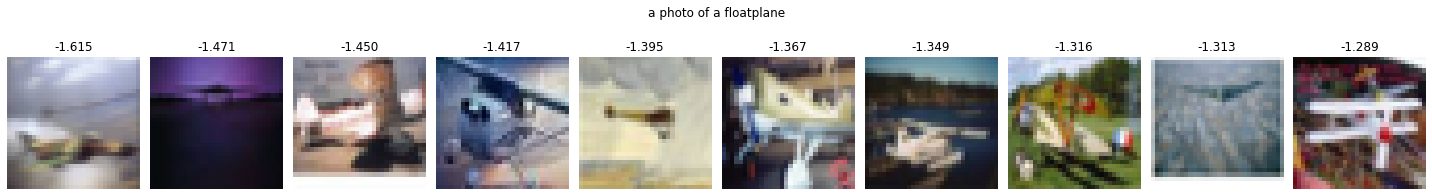

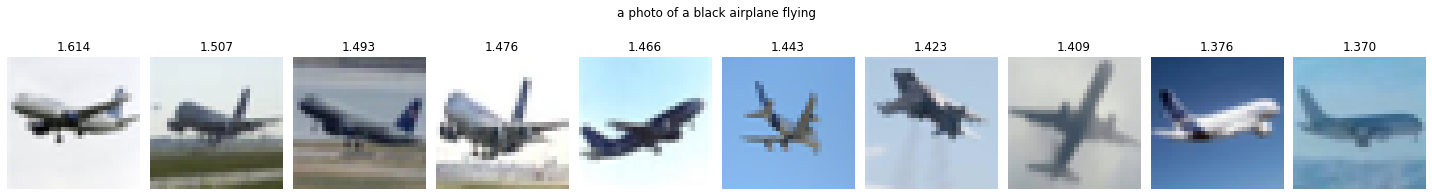



---


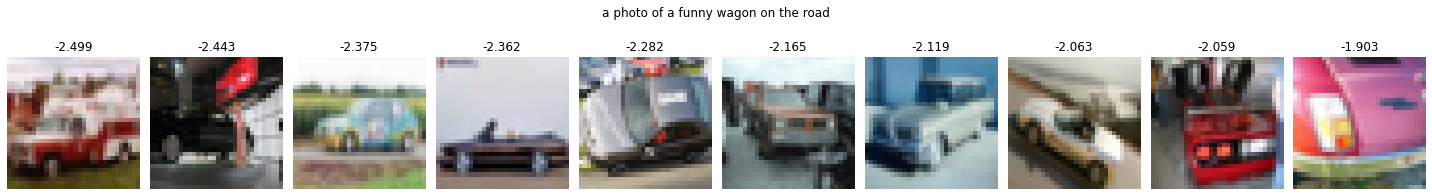

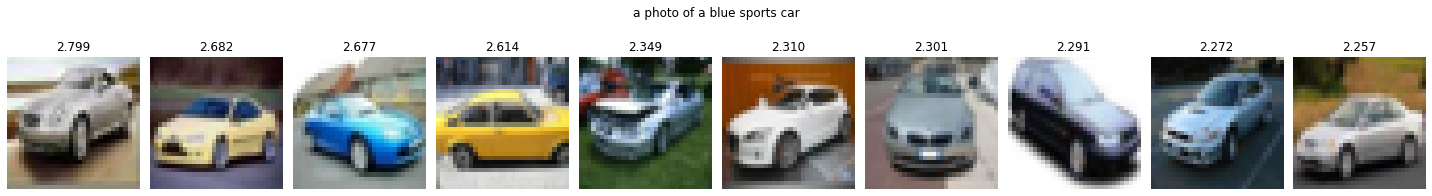



---


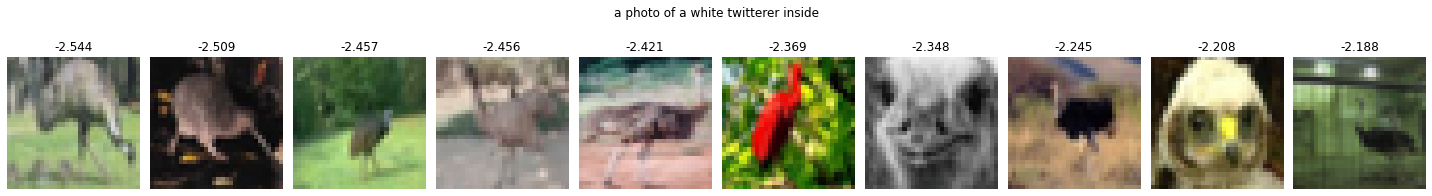

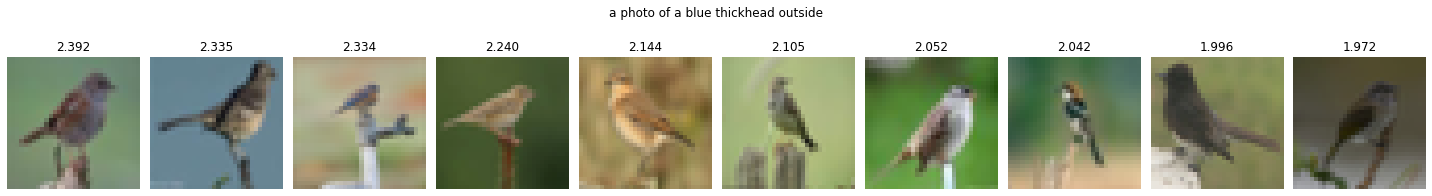



---


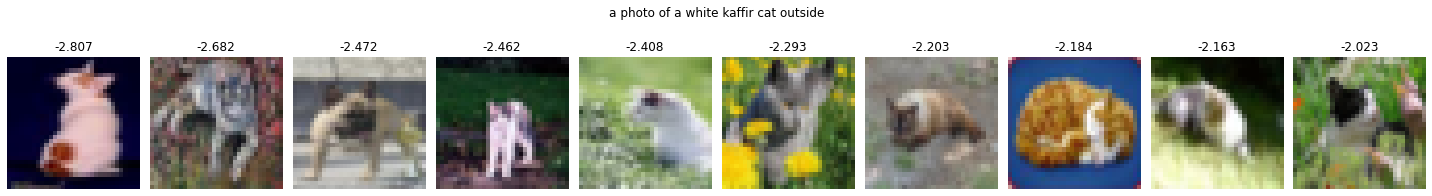

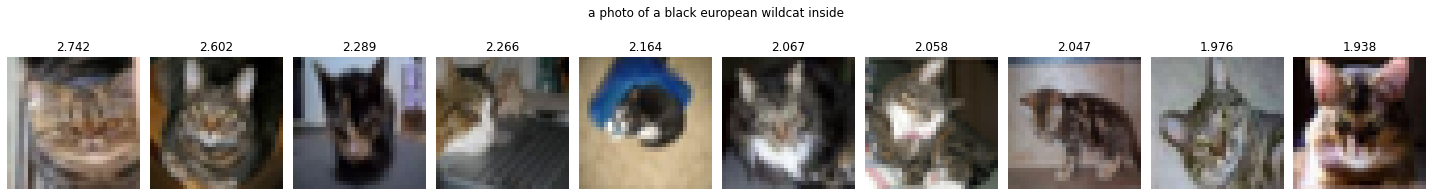



---


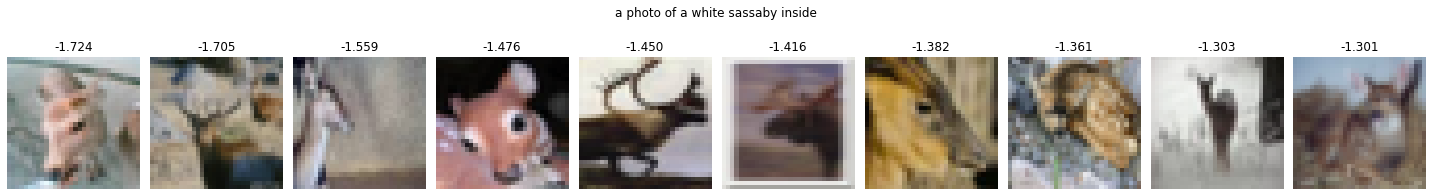

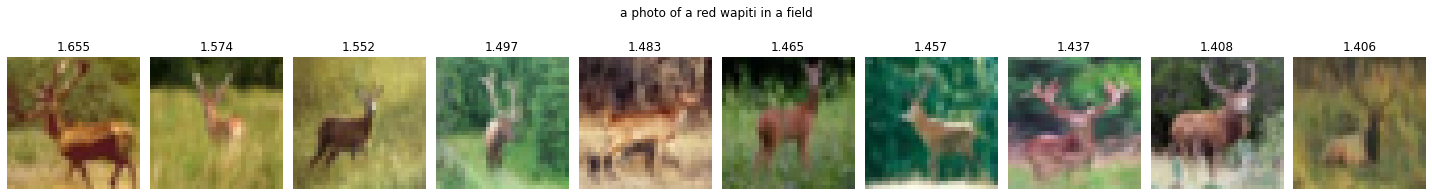



---


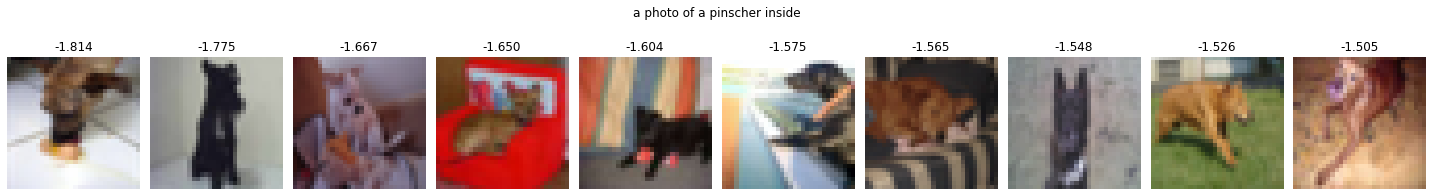

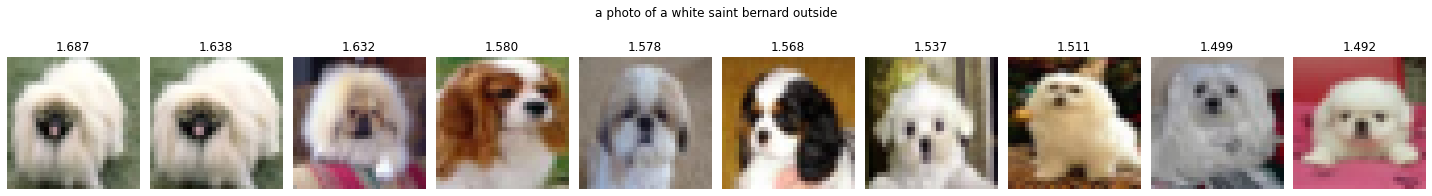



---


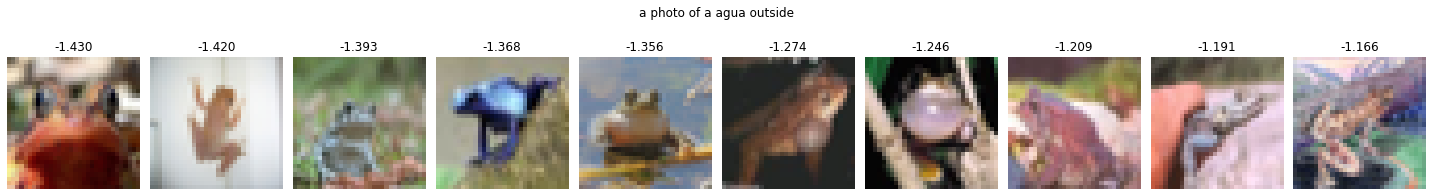

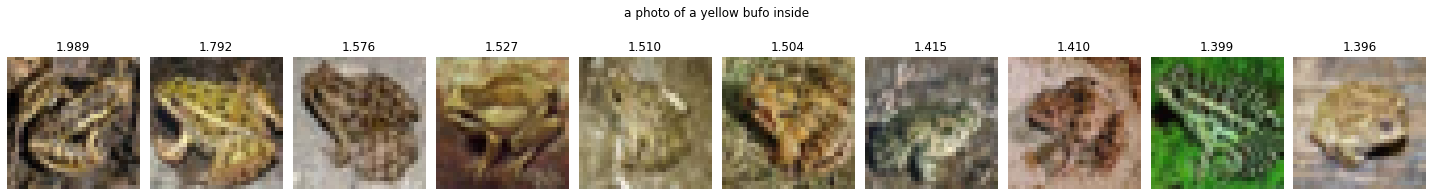



---


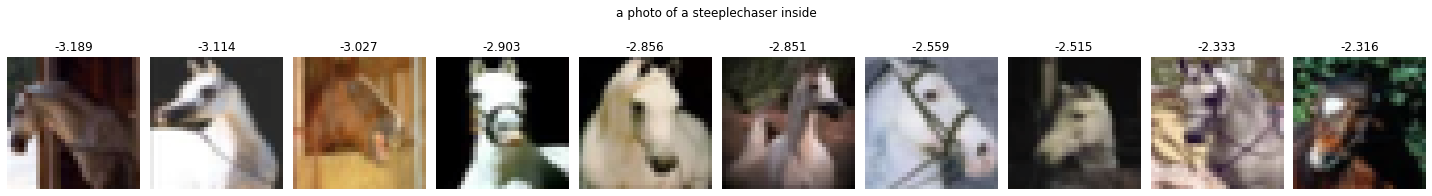

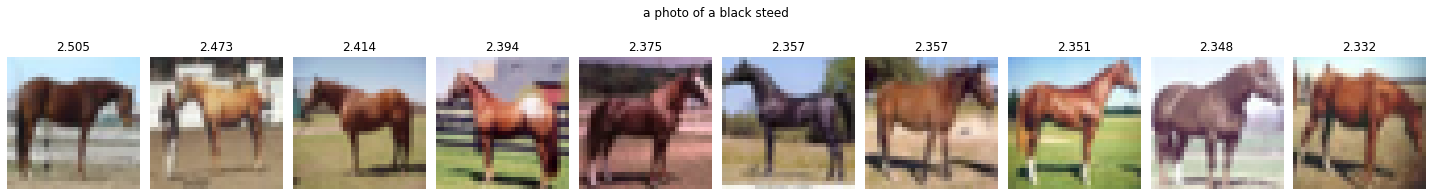



---


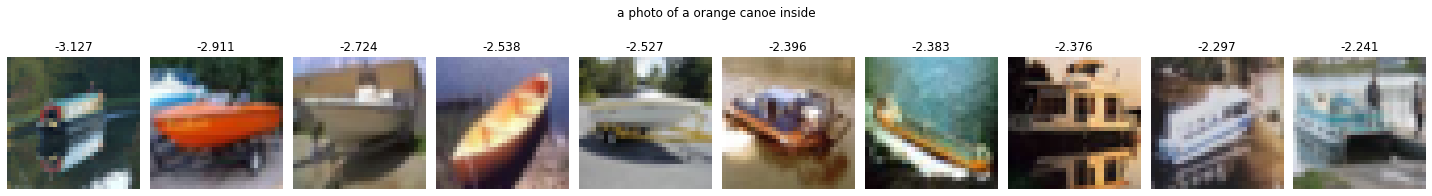

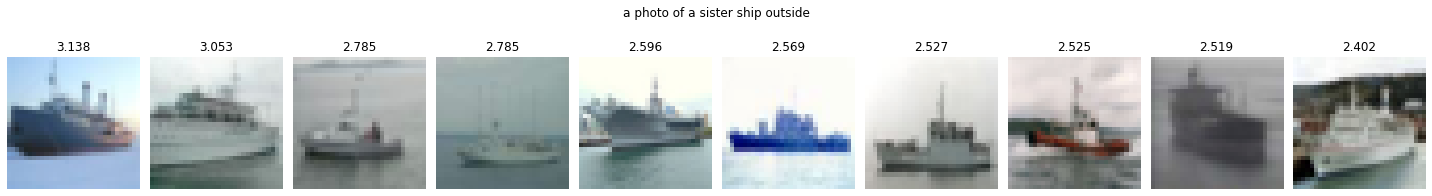



---


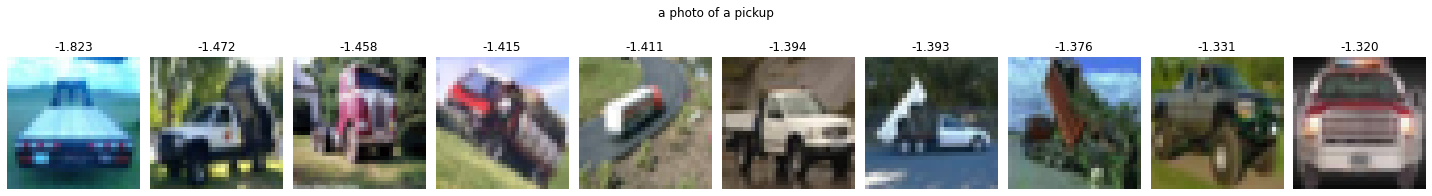

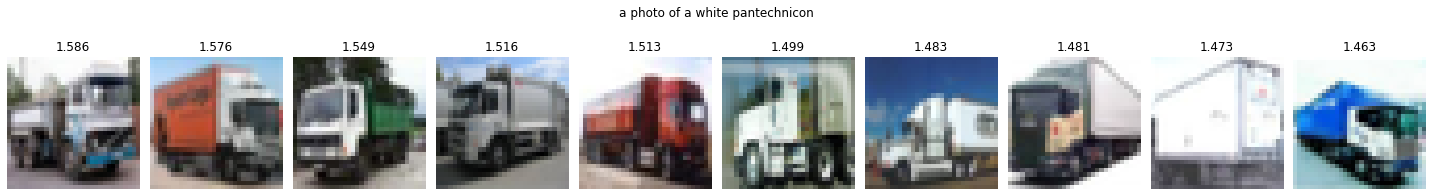

In [33]:

def visualize_images(ds, ds_indices, ds_values, K=10, title=""):
    fig, ax = plt.subplots(1, K, figsize=(K*2, 3))
    for i in range(K):
        idx = ds_indices[i]
        ax[i].imshow(TOIMAGE(ds[idx][0]))
        ax[i].axis(False)
        ax[i].set_title(f"{ds_values[i]:0.3f}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

gts = run_dict['test'][0]
for c in range(10):
    print("---")
    selected_caps = selected_captions[c]
    mask = gts == c
    masked_indices = np.arange(len(mask))[mask]
    dv = svm_decision_values['test'][mask]
    bottom_dv = np.argsort(dv)
    top_dv = bottom_dv[::-1]
    for order_name, order, cap in (
        ('bottom', bottom_dv, selected_caps[0]),
        ("top", top_dv, selected_caps[1]),
    ):
        vals = dv[order]
        visualize_images(test_ds, masked_indices[order], vals, title=cap)
        print("\n")
    